In [ ]:
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/study_ji_T/project/Generate_Realistic_Human_Face_using_GAN'):
  for filename in filenames:
    print(os.path.join(dirname,filename))

from matplotlib import pyplot as plt

from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

/content/drive/MyDrive/study_ji_T/project/Generate_Realistic_Human_Face_using_GAN/Generate Realistic Human Face using GAN.ipynb
/content/drive/MyDrive/study_ji_T/project/Generate_Realistic_Human_Face_using_GAN/img_align_celeba.zip
/content/drive/MyDrive/study_ji_T/project/Generate_Realistic_Human_Face_using_GAN/list_eval_partition.csv
/content/drive/MyDrive/study_ji_T/project/Generate_Realistic_Human_Face_using_GAN/list_bbox_celeba.csv
/content/drive/MyDrive/study_ji_T/project/Generate_Realistic_Human_Face_using_GAN/list_attr_celeba.csv
/content/drive/MyDrive/study_ji_T/project/Generate_Realistic_Human_Face_using_GAN/list_landmarks_align_celeba.csv


**Load the data and resize the images**

In [ ]:
PIC_DIR = f'/content/drive/MyDrive/study_ji_T/project/Generate_Realistic_Human_Face_using_GAN/img_align_celeba/'

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 200
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2 #원본 이미지의종횡비를 정사각형으로 만들기 위해 상단 및 하단에서 자를 양을 찾기 위한 것

WIDTH = 128
HEIGHT = 128

#(0,diff) : 삼각형이 좌상단 / (ORIG_WIDTH, ORIG_HEIGHT-diff) : 우하단
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT-diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
  pic = Img.open(PIC_DIR + pic_file).crop(crop_rect)
  pic.thumbnail((WIDTH, HEIGHT), Img.ANTIALIAS)
  images.append(np.uint8(pic))

  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-5-65359ef19d84>:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pic.thumbnail((WIDTH, HEIGHT), Img.ANTIALIAS)
100%|██████████| 10000/10000 [34:39<00:00,  4.81it/s]


In [ ]:
#Image shape
images = np.array(images) / 255 #이미지 데이터 정규화 작업
print(images.shape)

(10000, 128, 128, 3)


**Display first 25 images**

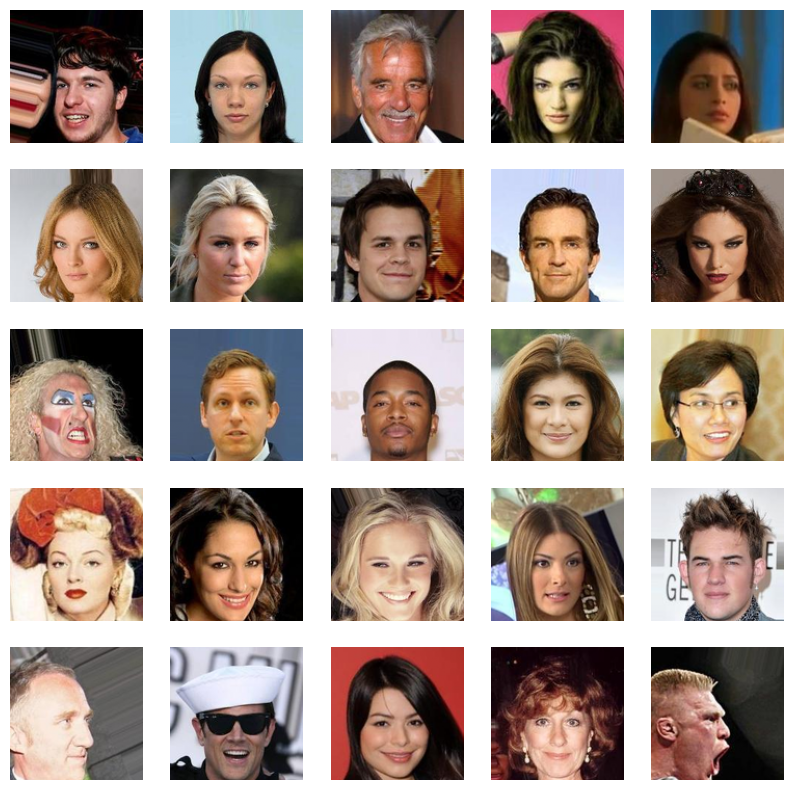

In [ ]:
plt.figure(1, figsize=(10,10))
for i in range(25) :
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i])
  plt.axis('off')
plt.show()

**create a Generator**

In [ ]:
LATENT_DIM = 32 #잠재 공간의 차원(dimension)
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

**create a Discriminator**

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    initial_learning_rate = 0.0001
    lr_schedule = ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )

    optimizer = RMSprop(learning_rate=lr_schedule, clipvalue=1.0)

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator


In [ ]:
from IPython.display import Image
from keras.utils import model_to_dot #버전 교체

In [ ]:
generator = create_generator()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       104883

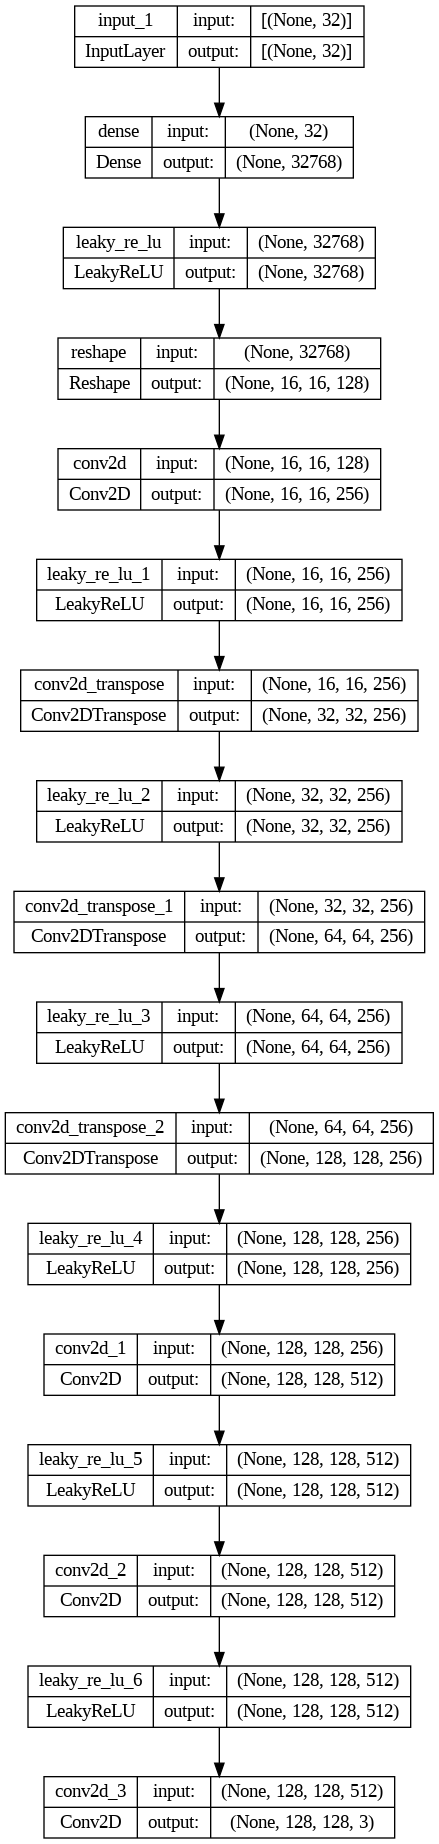

In [ ]:
Image(model_to_dot(generator, show_shapes=True).create_png())

In [ ]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

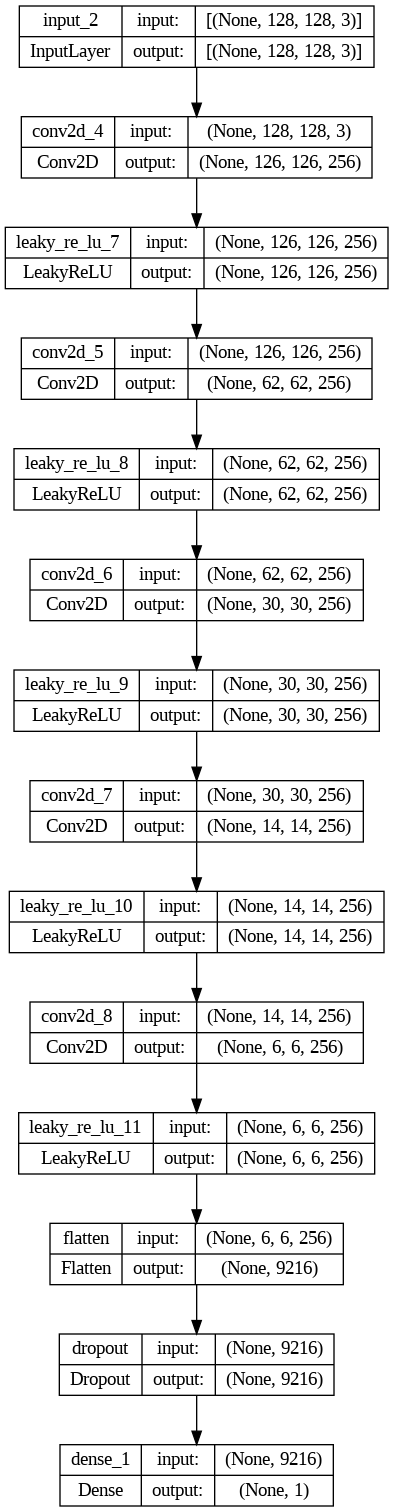

In [ ]:
Image(model_to_dot(discriminator, show_shapes=True).create_png())

In [ ]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=0.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model (Functional)          (None, 128, 128, 3)       14953987  
                                                                 
 model_1 (Functional)        (None, 1)                 4211713   
                                                                 
Total params: 19165700 (73.11 MB)
Trainable params: 14953987 (57.04 MB)
Non-trainable params: 4211713 (16.07 MB)
_________________________________________________________________


In [ ]:
import time
iters = 15000
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)

        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

1/1 [==============================] - 0s 18ms/step
50/15000: d_loss: -43235.0703,  a_loss: 9999145.0000.  (2.9 sec)
1/1 [==============================] - 0s 30ms/step
100/15000: d_loss: -143798.8125,  a_loss: 14121528.0000.  (3.5 sec)
1/1 [==============================] - 0s 18ms/step
150/15000: d_loss: -210680.4219,  a_loss: 31347848.0000.  (3.0 sec)
1/1 [==============================] - 0s 18ms/step
200/15000: d_loss: -634785.9375,  a_loss: 42893344.0000.  (2.9 sec)
1/1 [==============================] - 0s 18ms/step
250/15000: d_loss: -162538.4375,  a_loss: 67266240.0000.  (3.3 sec)
1/1 [==============================] - 0s 28ms/step
300/15000: d_loss: -535451.4375,  a_loss: 90555656.0000.  (2.9 sec)
1/1 [==============================] - 0s 18ms/step
350/15000: d_loss: -1191293.7500,  a_loss: 122002672.0000.  (2.9 sec)
1/1 [==============================] - 0s 18ms/step
400/15000: d_loss: 2937779.0000,  a_loss: 169819584.0000.  (3.5 sec)
1/1 [==============================] - 0

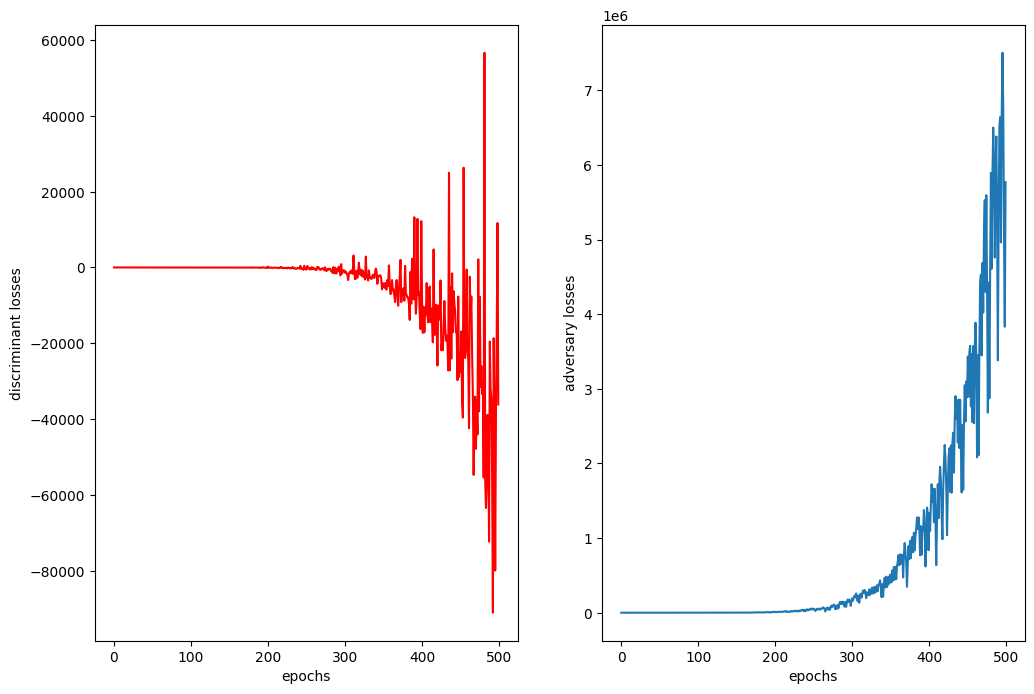

In [ ]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [ ]:
import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    file_path = os.path.join(RES_DIR, filename)
    images_to_gif.append(imageio.imread(file_path))

gif_path = 'training_visual.gif'
imageio.mimsave(gif_path, images_to_gif)

# Verify that the directory exists before attempting to remove it
if os.path.exists(RES_DIR):
    shutil.rmtree(RES_DIR)

print(f'GIF saved at: {gif_path}')

<ipython-input-21-197cca2d17b9>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_to_gif.append(imageio.imread(file_path))


GIF saved at: training_visual.gif


In [ ]:
print(len(images_to_gif))

30
